### Instructor Demo: Probable Outcomes of Stock Price Trajectory

This program executes `1000` simulations of stock price trajectory over the next `252` trading days (or year of trading), based on a normal probability distribution of average daily returns derived from the sample mean and standard deviation.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '2a5db6a2-c035-46cc-840f-fa519740a9b5',
     'marginable': True,
     'name': 'LifeSci Acquisition Corp. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'LSAC',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': '49b90cdc-f6f5-4a7c-807a-ed172e6017af',
     'marginable': True,
     'name': 'American Express Company',
     'shortable': True,
     'status': 'active',
     'symbol': 'AXP',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': 'f85c0ede-3556-4d0b-9e0c-4ffc2425044d',
     'marginable': True,
     'name': 'Diageo plc',
     'shortable': True,
     'status': 'active',
     'symbol': 'DEO',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'i

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,LSAC
1,AXP
2,OIL
3,CCA
4,CY
5,NFO
6,CBPX
7,GRSH_DELISTED
8,N014776_DELISTED
9,KOR


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "AAPL"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Format end_date and start_date with isoformat
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AAPL                                     
                              open      high      low   close    volume
2019-05-07 00:00:00-04:00  205.880  207.4175  200.825  202.86  34328425
2019-05-08 00:00:00-04:00  201.900  205.3400  201.750  202.90  22729670
2019-05-09 00:00:00-04:00  200.400  201.6800  196.660  200.72  32427147
2019-05-10 00:00:00-04:00  197.419  198.8500  192.770  197.30  36118438
2019-05-13 00:00:00-04:00  187.710  189.4800  182.850  185.72  50491792

### Drop Extraneous Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-07,202.86
2019-05-08,202.90
2019-05-09,200.72
2019-05-10,197.30
2019-05-13,185.72


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of AAPL
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-07,NaN
2019-05-08,0.000197
2019-05-09,-0.010744
2019-05-10,-0.017039
2019-05-13,-0.058692


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for AAPL
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.0018941677166472834

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for AAPL
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.025834053004570926

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations, trading days, and get last closing price of AAPL from DataFrame
num_simulations = 1000
num_trading_days = 252
aapl_last_price = df['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of AAPL
    simulated_aapl_prices = [aapl_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_aapl_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_aapl_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_aapl_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,...,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000,300.500000
1,290.189142,300.498579,310.131816,307.610893,311.028878,299.473949,297.076419,316.145053,294.197204,299.605573,...,312.764408,297.570580,301.646096,301.867782,298.555190,299.243017,303.909721,309.836350,306.447400,290.765441
2,293.174849,304.066060,310.266022,303.916199,302.644038,287.405893,304.702578,315.592946,286.330636,312.786367,...,324.403441,301.376715,308.021799,309.744035,302.485644,316.139720,311.465873,304.936486,315.710983,296.723521
3,311.884118,292.383226,308.971396,313.577744,314.208978,292.804473,304.150044,313.560829,287.332682,314.406380,...,326.949367,283.045132,316.135698,303.375481,310.011635,314.805194,314.033211,306.421113,298.236307,284.263498
4,313.931300,289.011538,315.363356,311.702235,309.550600,292.778019,316.982907,309.412726,284.322165,329.447305,...,319.479722,281.620830,325.652821,304.104893,300.080384,313.188323,317.929884,313.233710,308.616187,280.748166


### Plot the Multiple Simulations of Stock Price Trajectory for AAPL over the Next Year (252 Trading Days)

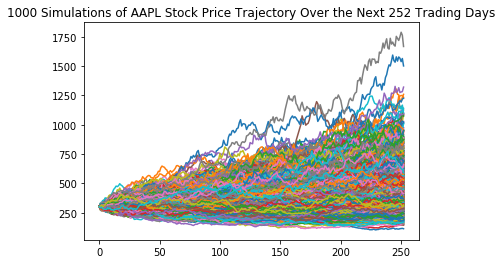

In [11]:
# Use the `plot` function to plot the trajectory of AAPL stock based on a 252 trading day simulation
plot_title = f"{n+1} Simulations of AAPL Stock Price Trajectory Over the Next 252 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for projecting stock prices (prices of each simulation on the 252nd trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1     881.590809
Simulation 2     486.177551
Simulation 3     528.183420
Simulation 4     421.418897
Simulation 5    1100.219594
Name: 252, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Prices on 252nd Trading Day

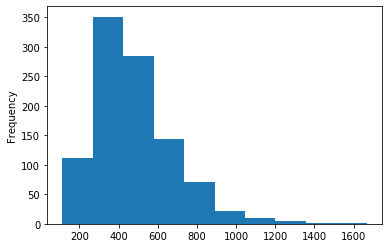

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist')

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Stock Prices of AAPL

In [14]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025    196.166320
0.975    951.178069
Name: 252, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Prices 

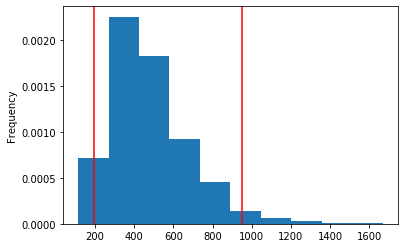

In [15]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in AAPL over the Next 252 Trading Days

In [16]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - aapl_last_price) / aapl_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - aapl_last_price) / aapl_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in AAPL"
      f" over the next 252 trading days will end within the range of"
      f" ${ending_investment_lower_bound} and ${ending_investment_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in AAPL over the next 252 trading days will end within the range of $6527.9973257677575 and $31653.18034490805
